# Assignment 2

- Sampad Kumar Kar
- MCS202215

# 0. Imports

In [1]:
# to handle files
import json
import os
import glob

# import regular expressions
import re

# pre-processing imports
import numpy as np
import pandas as pd

# NLKT preprocessing imports
import nltk
from nltk import download
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize , word_tokenize, RegexpTokenizer, PunktSentenceTokenizer

# for plotting
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# to view loop progress
from tqdm import tqdm

# to generate random no.s
import random

# to save dictionary
import pickle

# import priority queue
import heapq

# to handle large matrices
import h5py

# default dict
from collections import defaultdict

# keep track of runtime
from time import time

In [2]:
# Download required NLTK data
download('stopwords')
download('words')
download('wordnet')
download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sampadk04/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/sampadk04/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sampadk04/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sampadk04/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# extract the dictionary vocab
words = set(nltk.corpus.words.words())
wordnets = set(nltk.corpus.wordnet.words())
dictionary_vocab = set(words.union(wordnets))

# extarct the stop words
stopwords_vocab = set(nltk.corpus.stopwords.words())

# 1. Extracting Corpus Vocabulary

In [2]:
my_corpus_folder_path = os.path.join(os.pardir, 'data', 'my_corpus')
my_corpus_folder_path

'../data/my_corpus'

In [3]:
corpus_path = os.path.join(my_corpus_folder_path, 'corpus_1.txt')
corpus_path

'../data/my_corpus/corpus_1.txt'

In [10]:
def find_words_freq(corpus_path, freq_threshold = 10):
    # initialize dictionary to store frequency count of the words
    corpus_vocab_freq = dict()
    paper_count = 0

    corpus = open(corpus_path, 'r')
    
    # read the papers one after another and process
    # Note: we consider sentence[:-1] to remove the '\n' character
    paper_data = corpus.readline()[:-1]

    # run the loop till we reach the end of the document
    while paper_data:
        # tokenize the paper
        paper_words = word_tokenize(paper_data)
        # process word by word
        for word in paper_words:
            if word not in corpus_vocab_freq:
                corpus_vocab_freq[word] = 1
            else:
                corpus_vocab_freq[word] += 1
        
        # read the next paper_data
        paper_data = corpus.readline()[:-1]

        # increase paper_count
        paper_count += 1
        # print info to keep track of progress
        if paper_count%10000 == 0:
            print("-"*20)
            print(f"Document #: {paper_count}; Vocabulary Size: {len(corpus_vocab_freq)}")

    corpus.close()

    # initialize set to store vocabulary of the corpus, to store words having frequency >= freq_threshold
    corpus_vocab = set()
    for word in corpus_vocab_freq:
        if corpus_vocab_freq[word] >= freq_threshold:
            corpus_vocab.add(word)

    corpus_vocab = sorted(corpus_vocab)

    return corpus_vocab, corpus_vocab_freq

In [4]:
freq_threshold=20

In [17]:
corpus_vocab, corpus_vocab_freq = find_words_freq(corpus_path, freq_threshold=freq_threshold)

print("\nFiltered Corpus Vocabulary Size:", len(corpus_vocab))

--------------------
Document #: 10000; Vocabulary Size: 47398
--------------------
Document #: 20000; Vocabulary Size: 56146
--------------------
Document #: 30000; Vocabulary Size: 61326
--------------------
Document #: 40000; Vocabulary Size: 65566
--------------------
Document #: 50000; Vocabulary Size: 68603

Filtered Corpus Vocabulary Size: 32133


In [18]:
corpus_vocab = set()
for word in corpus_vocab_freq:
    if corpus_vocab_freq[word] >= freq_threshold:
        corpus_vocab.add(word)

corpus_vocab = sorted(corpus_vocab)
print(len(corpus_vocab))

32133


## 1.1 Saving and Loading Corpus Vocabulary

In [5]:
corpus_vocab_path = os.path.join('corpus_vocabs', 'corpus_vocab_ft' + str(freq_threshold) + '.pickle')
corpus_vocab_path

'corpus_vocabs/corpus_vocab_ft20.pickle'

In [20]:
# saving the corpus_vocab
'''
fh = open(corpus_vocab_path, "wb")
pickle.dump(corpus_vocab, fh)
fh.close()
'''

In [6]:
# loading the corpus_vocab
fh = open(corpus_vocab_path, 'rb')
corpus_vocab = pickle.load(fh)
fh.close()

# 2.  Hyperspace Analogue to Language (HAL)

In [7]:
def extract_corpus_tokens(corpus_path, corpus_vocab, batch_size=60000):
    # extract vocab_count
    corpus_vocab = sorted(corpus_vocab)
    
    # initialize corpus_tokens
    corpus_tokens = []
    
    # keep track of time taken to tokenize corpus
    st = time()
    
    corpus = open(corpus_path, 'r')
    
    # read the papers one after another and process
    # Note: we consider sentence[:-1] to remove the '\n' character
    paper_data = corpus.readline()[:-1]

    # to store the # of papers read from the corpus
    paper_count = 1

    # run the loop till we have read `batch_size` no. of documents or read all the documents from the whole corpus
    while (paper_data) and (paper_count <= batch_size):
        paper_tokens = word_tokenize(paper_data)
        corpus_tokens.extend(paper_tokens)
        
        # read the next paper_data
        paper_data = corpus.readline()[:-1]
        
        # increase paper count
        paper_count += 1
        # print info to keep track of progress
        if paper_count%5000 == 0:
            print("-"*20)
            print(f"Document #: {paper_count}")
    
        # close the filehandlers
    corpus.close()

    ed = time()
    
    print("\nCorpus Successfully Tokenized! \n")

    print("Time taken to tokenize:", ed-st)

    st = time()

    # filter corpus
    for i in tqdm(range(len(corpus_tokens))):
        token = corpus_tokens[i]
        if token not in corpus_vocab:
            corpus_tokens[i] = ''

    ed = time()

    print("Time taken to filter tokens:", ed-st)

    return corpus_tokens

In [9]:
corpus_tokens = extract_corpus_tokens(
    corpus_path=corpus_path,
    corpus_vocab=corpus_vocab
)

--------------------
Document #: 5000
--------------------
Document #: 10000
--------------------
Document #: 15000
--------------------
Document #: 20000
--------------------
Document #: 25000
--------------------
Document #: 30000
--------------------
Document #: 35000
--------------------
Document #: 40000
--------------------
Document #: 45000
--------------------
Document #: 50000
--------------------
Document #: 55000

Corpus Successfully Tokenized! 

Time taken to tokenize: 237.8611183166504


100%|██████████| 109423063/109423063 [5:27:12<00:00, 5573.69it/s]  

Time taken to filter tokens: 19632.097134828568


In [10]:
corpus_tokens_path = os.path.join('corpus_tokens', 'corpus_tokens.pickle')
corpus_tokens_path

'corpus_tokens/corpus_tokens.pickle'

In [11]:
# saving the corpus_tokens
'''
fh = open(corpus_tokens_path, "wb")
pickle.dump(corpus_tokens, fh)
fh.close()
'''

In [ ]:
# loading the corpus_vocab
fh = open(corpus_tokens_path, 'rb')
corpus_tokens = pickle.load(fh)
fh.close()

In [12]:
def HAL(corpus_tokens, corpus_vocab, window_size=10):
    # extract vocab_count
    corpus_vocab = sorted(corpus_vocab)
    vocab_count = len(corpus_vocab)

    # initialize HAL_matrix
    HAL_mat = np.zeros((vocab_count, vocab_count))

    # map words in vocab to their indices
    vocab_idx = dict((w,i) for i,w in enumerate(corpus_vocab))

    # track time for the experiment
    st = time()

    for i in tqdm(range(window_size, len(corpus_tokens)-window_size)):
        for j in range(1,window_size+1):
            if corpus_tokens[i] and corpus_tokens[i+j]:
                idx_i = vocab_idx[corpus_tokens[i]]
                idx_ipj = vocab_idx[corpus_tokens[i+j]]
                
                # left to right update
                HAL_mat[idx_i, idx_ipj] += j

                # right to left update
                HAL_mat[idx_ipj, idx_i] += j
    
    ed = time()

    print("Time taken to update HAL Matrix:", ed-st)

    return HAL_mat

In [13]:
# we process the whole batch together

HAL_mat = HAL(
                corpus_tokens=corpus_tokens,
                corpus_vocab=corpus_vocab,
                window_size=10,
            )

100%|██████████| 109423043/109423043 [17:11<00:00, 106089.53it/s]

Time taken to update HAL Matrix: 1031.4236688613892


In [7]:
hal_matrix_path = os.path.join('hal_matrix', 'HAL.pickle')
hal_matrix_path

'hal_matrix/HAL.pickle'

In [15]:
# saving the HAL Matrix
'''
fh = open(hal_matrix_path, "wb")
pickle.dump(HAL_mat, fh)
fh.close()
'''

In [8]:
# loading the HAL Matrix
fh = open(hal_matrix_path, 'rb')
HAL_mat = pickle.load(fh)
fh.close()

In [16]:
def word_vec(word, corpus_vocab, HAL_mat):
    if word not in corpus_vocab:
        print("Word not found in Vocabulary!")
        return None
    else:
        # extract the corpus vocabulary index into a dictionary
        vocab_idx = dict((w,i) for i,w in enumerate(corpus_vocab))

        # extract index of the word
        word_idx = vocab_idx[word]

        # extract vector corresponding to the word
        word_vec = HAL_mat[word_idx]
        
        return word_vec

In [18]:
def k_closest_words(tag_word, k, corpus_vocab, HAL_mat):
    if tag_word not in corpus_vocab:
        print("Word not found in Vocabulary!")
    else:
        vocab_count = len(corpus_vocab)
        
        # extract the corpus vocabulary index into a dictionary
        vocab_idx = dict((w,i) for i,w in enumerate(corpus_vocab))
        # extract the word_idx to word correspondence into a dictionary
        idx_to_word = dict((i,w) for i,w in enumerate(corpus_vocab))

        # extract index of the word
        tag_word_idx = vocab_idx[tag_word]

        # extract vector corresponding to the word
        tag_word_vec = HAL_mat[tag_word_idx]
        tag_word_vec_norm = np.linalg.norm(tag_word_vec)
        if tag_word_vec_norm != 0:
            tag_word_vec = tag_word_vec/tag_word_vec_norm


        # initialize queue to hold distance
        nearest_k_queue = []

        for i in tqdm(range(vocab_count)):
            word_vec = HAL_mat[i]
            word_vec_norm = np.linalg.norm(word_vec)
            if word_vec_norm != 0:
                word_vec = word_vec/word_vec_norm

            # calculate distance
            word_dist = tag_word_vec-word_vec
            

            word_dist = np.linalg.norm(tag_word_vec-word_vec)

            if len(nearest_k_queue) < k+1:
                heapq.heappush(nearest_k_queue, (-word_dist, i))
            else:
                # extract the kth nearest distance from tag_word in the nearest_k_queue
                kth_dist = - nearest_k_queue[0][0]

                # update nearest_k_queue
                if word_dist < kth_dist:
                    heapq.heappop(nearest_k_queue)
                    heapq.heappush(nearest_k_queue, (-word_dist, i))
        

        nearest_k_queue = list(sorted(nearest_k_queue, reverse=True))

        print("Nearest " + str(k) + " words:")
        for (i, (neg_dist, word_idx)) in enumerate(nearest_k_queue):
            nearest_k_queue[i] = -neg_dist, word_idx
            # print nearest words
            word = idx_to_word[word_idx]
            print(word + "               ||  Distance: " + str(-neg_dist))
        
        return nearest_k_queue

In [12]:
_ = k_closest_words(
    tag_word='covid',
    k=5,
    corpus_vocab=corpus_vocab,
    HAL_mat=HAL_mat
)

100%|██████████| 32133/32133 [00:04<00:00, 7144.41it/s]

Nearest 5 words:
covid               ||  Distance: 0.0
ongoing               ||  Distance: 0.387042179672142
urgent               ||  Distance: 0.4090130861973963
severely               ||  Distance: 0.43000372286915733
vigilant               ||  Distance: 0.44246018513104923
urgency               ||  Distance: 0.4475025552750839


In [31]:
_ = k_closest_words(
    tag_word='travel',
    k=5,
    corpus_vocab=corpus_vocab,
    HAL_mat=HAL_mat
)

100%|██████████| 32133/32133 [00:04<00:00, 7013.61it/s]

Nearest 5 words:
travel               ||  Distance: 0.0
traveler               ||  Distance: 0.4878580340857557
abroad               ||  Distance: 0.5191748683611999
traveller               ||  Distance: 0.5466008619189272
overseas               ||  Distance: 0.5585505284364755
arrive               ||  Distance: 0.5716317081210442


In [31]:
_ = k_closest_words(
    tag_word='country',
    k=5,
    corpus_vocab=corpus_vocab,
    HAL_mat=HAL_mat
)

100%|██████████| 32133/32133 [00:04<00:00, 6638.89it/s]

Nearest 5 words:
country               ||  Distance: 0.0
brazil               ||  Distance: 0.4421653388783842
continent               ||  Distance: 0.4569634026232744
territory               ||  Distance: 0.45781450240832666
spain               ||  Distance: 0.4684622379216126
italy               ||  Distance: 0.48327373595709844


In [20]:
_ = k_closest_words(
    tag_word='marijuana',
    k=5,
    corpus_vocab=corpus_vocab,
    HAL_mat=HAL_mat
)

100%|██████████| 32133/32133 [00:06<00:00, 5354.78it/s]

Nearest 5 words:
marijuana               ||  Distance: 0.0
casual               ||  Distance: 0.8756763760570967
report               ||  Distance: 0.8767095547734073
case               ||  Distance: 0.8824562105345342
notice               ||  Distance: 0.8877136745958124
fourth               ||  Distance: 0.8889641336526068


In [21]:
_ = k_closest_words(
    tag_word='disease',
    k=5,
    corpus_vocab=corpus_vocab,
    HAL_mat=HAL_mat
)

100%|██████████| 32133/32133 [00:04<00:00, 6492.86it/s]

Nearest 5 words:
disease               ||  Distance: 0.0
underlie               ||  Distance: 0.34295891430426834
afflict               ||  Distance: 0.3508218705383072
preexist               ||  Distance: 0.38358701673546736
chronic               ||  Distance: 0.3838702557965244
morbidity               ||  Distance: 0.4071870008596056


In [22]:
_ = k_closest_words(
    tag_word='hospital',
    k=5,
    corpus_vocab=corpus_vocab,
    HAL_mat=HAL_mat
)

100%|██████████| 32133/32133 [00:04<00:00, 6617.64it/s]

Nearest 5 words:
hospital               ||  Distance: 0.0
inpatient               ||  Distance: 0.31209979621604156
admit               ||  Distance: 0.34378883977871627
outpatient               ||  Distance: 0.369771786049285
ambulatory               ||  Distance: 0.39317167243055545
intensive               ||  Distance: 0.3982923711299015


# 3. Visualizing Distances

In [14]:
HAL_mat_scaled = HAL_mat/np.linalg.norm(HAL_mat)

In [15]:
pca = PCA(n_components=200)
HAL_mat_scaled_pca = pca.fit_transform(HAL_mat_scaled)

In [16]:
hal_matrix_scaled_pca_path = os.path.join('hal_matrix', 'HAL_scaled_pca200.pickle')
hal_matrix_scaled_pca_path

'hal_matrix/HAL_scaled_pca200.pickle'

In [17]:
# saving the HAL Matrix PCA
'''
fh = open(hal_matrix_scaled_pca_path, "wb")
pickle.dump(HAL_mat_scaled_pca, fh)
fh.close()
'''

In [ ]:
# loading the HAL Matrix PCA
fh = open(hal_matrix_scaled_pca_path, 'rb')
HAL_mat_scaled_pca = pickle.load(fh)
fh.close()

In [24]:
def plot_k_closest_words(tag_word, k, corpus_vocab, HAL_mat, HAL_mat_pca):
    # extract the word_idx to word correspondence into a dictionary
    idx_to_word = dict((i,w) for i,w in enumerate(corpus_vocab))
    
    # extract nearest k words
    nearest_k_words = k_closest_words(tag_word, k, corpus_vocab, HAL_mat)
    
    # word_vec list
    word_vecs = []
    for (dist, word_idx) in nearest_k_words:
        word_vec_pca = HAL_mat_pca[word_idx]
        word_vecs.append(word_vec_pca)
    
    word_vecs = np.array(word_vecs)
    word_vecs_embed = TSNE(n_components=2, perplexity=3).fit_transform(word_vecs)
    x,y = word_vecs_embed[:,0], word_vecs_embed[:,1]

    print("")
    plt.figure()
    plt.scatter(x,y)
    for (i, (_, word_idx)) in enumerate(nearest_k_words):
        word = idx_to_word[word_idx]
        plt.annotate(word, (x[i],y[i]))
    plt.title("TNSE Plot")
    plt.show()    

100%|██████████| 32133/32133 [00:04<00:00, 6622.86it/s]


Nearest 10 words:
covid               ||  Distance: 0.0
ongoing               ||  Distance: 0.387042179672142
urgent               ||  Distance: 0.4090130861973963
severely               ||  Distance: 0.43000372286915733
vigilant               ||  Distance: 0.44246018513104923
urgency               ||  Distance: 0.4475025552750839
anecdotal               ||  Distance: 0.4489786298120328
pandemic               ||  Distance: 0.44929037267443434
reassure               ||  Distance: 0.45012921646741216
escalate               ||  Distance: 0.45194285990520977
scarce               ||  Distance: 0.45524596124932304



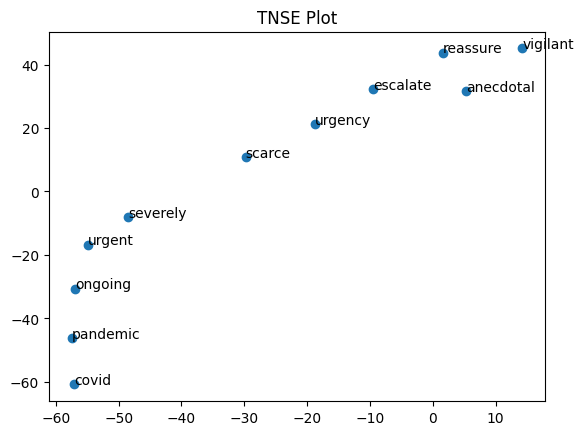

In [25]:
plot_k_closest_words(
    tag_word='covid',
    k=10,
    corpus_vocab=corpus_vocab,
    HAL_mat=HAL_mat,
    HAL_mat_pca=HAL_mat_scaled_pca
)

100%|██████████| 32133/32133 [00:04<00:00, 6560.66it/s]


Nearest 10 words:
travel               ||  Distance: 0.0
traveler               ||  Distance: 0.4878580340857557
abroad               ||  Distance: 0.5191748683611999
traveller               ||  Distance: 0.5466008619189272
overseas               ||  Distance: 0.5585505284364755
arrive               ||  Distance: 0.5716317081210442
impose               ||  Distance: 0.5832211736446828
internationally               ||  Distance: 0.6004146503460965
strict               ||  Distance: 0.6122943952989055
close               ||  Distance: 0.6142165084950754
spread               ||  Distance: 0.6179010404660625



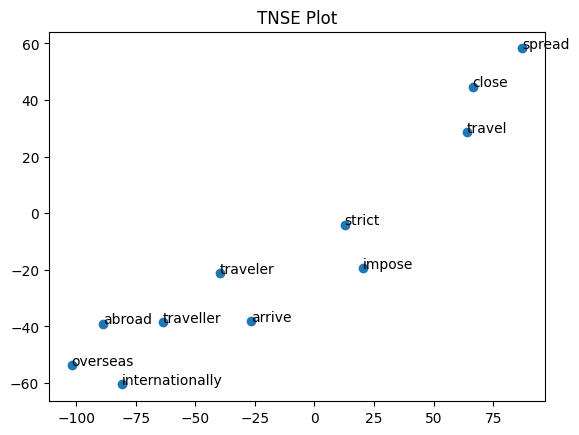

In [27]:
plot_k_closest_words(
    tag_word='travel',
    k=10,
    corpus_vocab=corpus_vocab,
    HAL_mat=HAL_mat,
    HAL_mat_pca=HAL_mat_scaled_pca
)

100%|██████████| 32133/32133 [00:04<00:00, 6514.14it/s]


Nearest 10 words:
country               ||  Distance: 0.0
brazil               ||  Distance: 0.4421653388783842
continent               ||  Distance: 0.4569634026232744
territory               ||  Distance: 0.45781450240832666
spain               ||  Distance: 0.4684622379216126
italy               ||  Distance: 0.48327373595709844
south               ||  Distance: 0.483960196093335
world               ||  Distance: 0.48520427738453487
internationally               ||  Distance: 0.4853225003654655
pakistan               ||  Distance: 0.48669467170121394
europe               ||  Distance: 0.4893458361672787



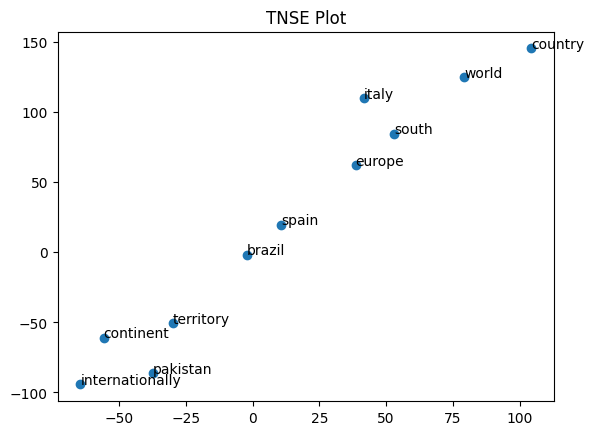

In [32]:
plot_k_closest_words(
    tag_word='country',
    k=10,
    corpus_vocab=corpus_vocab,
    HAL_mat=HAL_mat,
    HAL_mat_pca=HAL_mat_scaled_pca
)

100%|██████████| 32133/32133 [00:04<00:00, 6602.88it/s]


Nearest 10 words:
marijuana               ||  Distance: 0.0
casual               ||  Distance: 0.8756763760570967
report               ||  Distance: 0.8767095547734073
case               ||  Distance: 0.8824562105345342
notice               ||  Distance: 0.8877136745958124
fourth               ||  Distance: 0.8889641336526068
deny               ||  Distance: 0.8923456330247792
greater               ||  Distance: 0.8938345181238048
note               ||  Distance: 0.8948281648401264
proportion               ||  Distance: 0.8951716633784217
fewer               ||  Distance: 0.8955052293849584



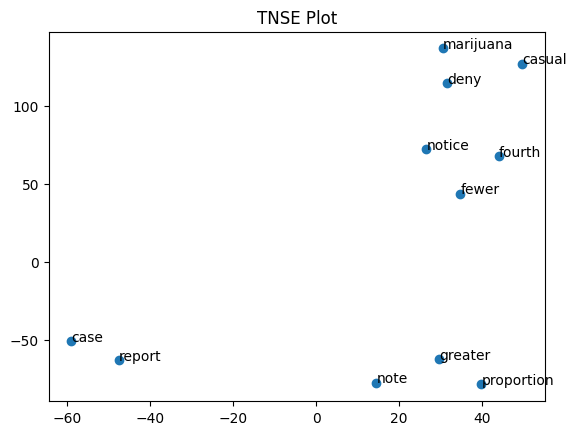

In [28]:
plot_k_closest_words(
    tag_word='marijuana',
    k=10,
    corpus_vocab=corpus_vocab,
    HAL_mat=HAL_mat,
    HAL_mat_pca=HAL_mat_scaled_pca
)

100%|██████████| 32133/32133 [00:04<00:00, 6538.11it/s]


Nearest 10 words:
disease               ||  Distance: 0.0
underlie               ||  Distance: 0.34295891430426834
afflict               ||  Distance: 0.3508218705383072
preexist               ||  Distance: 0.38358701673546736
chronic               ||  Distance: 0.3838702557965244
morbidity               ||  Distance: 0.4071870008596056
infectious               ||  Distance: 0.4079327867188203
progress               ||  Distance: 0.40985497684758243
manifest               ||  Distance: 0.41669367616482633
fatal               ||  Distance: 0.41848238073644806
especially               ||  Distance: 0.42443952434682397



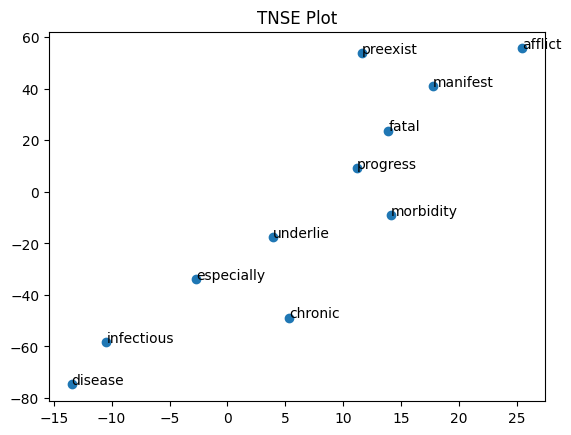

In [29]:
plot_k_closest_words(
    tag_word='disease',
    k=10,
    corpus_vocab=corpus_vocab,
    HAL_mat=HAL_mat,
    HAL_mat_pca=HAL_mat_scaled_pca
)

100%|██████████| 32133/32133 [00:04<00:00, 6607.69it/s]


Nearest 10 words:
hospital               ||  Distance: 0.0
inpatient               ||  Distance: 0.31209979621604156
admit               ||  Distance: 0.34378883977871627
outpatient               ||  Distance: 0.369771786049285
ambulatory               ||  Distance: 0.39317167243055545
intensive               ||  Distance: 0.3982923711299015
tertiary               ||  Distance: 0.4010801448364555
referral               ||  Distance: 0.4091421708366363
department               ||  Distance: 0.4218822288942798
admission               ||  Distance: 0.4229855774831047
hospitalize               ||  Distance: 0.43470559156722643



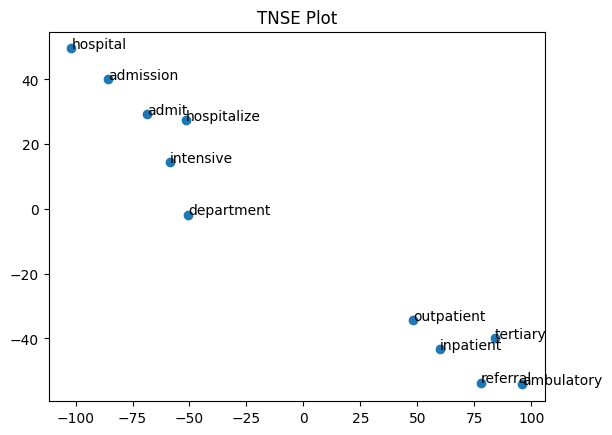

In [30]:
plot_k_closest_words(
    tag_word='hospital',
    k=10,
    corpus_vocab=corpus_vocab,
    HAL_mat=HAL_mat,
    HAL_mat_pca=HAL_mat_scaled_pca
)